An example of interpolation (Integrated with other notebooks)
----

1. Download Baker DEM file

See contributors/friedrichknuth/download_reference_dem.ipynb for more details

In [1]:
# # Comment this cell for downloading Baker DEM

# %%capture
# current_directory = !pwd
# current_directory = current_directory[0]
# %cd ~/
# ! git clone https://github.com/friedrichknuth/driveanon.git
# ! pip install ./driveanon
# %cd {current_directory}
# import driveanon
# blob_id = '1-8Ca-9_HJL4S7CrX4x5hzH-nrjD4Thpq'
# %mkdir ~/data
# %cd ~/data
# driveanon.save(blob_id)
# %cd {current_directory}
# ! gdalinfo ~/data/reference_dem_clip.tif

2. Load the Baker DEM file as reference_dem class, get bounding box for downloading ICESat-2 data

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('/home/jovyan/Assimilation/simlib'))
from coregistration import reference_dem
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
# %matplotlib widget
# %load_ext autoreload
# %autoreload 2

dem_path = '/home/jovyan/data/reference_dem_clip.tif'
dem = reference_dem(dem_path)
dem.calculate_bounding_box('4326')
bbox = dem.bbox
print(bbox)
print(dem.epsg)

# Baken DEM EPSG: 32610

[-121.87893182746436, 48.70258466806347, -121.79542720391288, 48.7704252035505]
32610


3. Download ICESat-2 data

See contributors/icetianli/READ_ATL06.ipynb for more datil

In [3]:
# # Comment this cell for downloading ICESat-2 data

# from icepyx import icesat2data as ipd

# # query datasets
# short_name = 'ATL06'
# date_range = ['2018-10-14','2020-04-04']
# bbox = [-121.87893182746436, 48.70258466806347, -121.79542720391288, 48.7704252035505] #[lonmin,latmin,lonmax,latmax]

# # Earthdata Login user name and associated email
# earthdata_uid = 'jhsttshj'
# email = 'wz278@cornell.edu'

# region = ipd.Icesat2Data(short_name, bbox, date_range)
# region.earthdata_login(earthdata_uid, email)
# region.download_granules('/home/jovyan/data/ICESat-2_Baker')

4. Load ICESat-2 data

See contributors/icetianli/READ_ATL06.ipynb for more datil

In [4]:
import glob
import dask.dataframe as dd
import atl06lib

# files = glob.glob('/home/jovyan/data/ICESat-2_Baker/*.h5')
# outdir = '/home/jovyan/data/ICESat-2_Baker_Processed'
# # print(files)

# for f in files:
#     atl06lib.read_atl06(f, dem.epsg, outdir, bbox)

!du -hs /home/jovyan/data/ICESat-2_Baker_Processed/*.h5

12K	/home/jovyan/data/ICESat-2_Baker_Processed/processed_ATL06_20181019231110_03260102_003_01_gt1l.h5
16K	/home/jovyan/data/ICESat-2_Baker_Processed/processed_ATL06_20181019231110_03260102_003_01_gt1r.h5
20K	/home/jovyan/data/ICESat-2_Baker_Processed/processed_ATL06_20181019231110_03260102_003_01_gt2l.h5
24K	/home/jovyan/data/ICESat-2_Baker_Processed/processed_ATL06_20181019231110_03260102_003_01_gt2r.h5
24K	/home/jovyan/data/ICESat-2_Baker_Processed/processed_ATL06_20190129064202_04860206_003_01_gt3l.h5
28K	/home/jovyan/data/ICESat-2_Baker_Processed/processed_ATL06_20190129064202_04860206_003_01_gt3r.h5
12K	/home/jovyan/data/ICESat-2_Baker_Processed/processed_ATL06_20190430022142_04860306_003_01_gt1l.h5
12K	/home/jovyan/data/ICESat-2_Baker_Processed/processed_ATL06_20190430022142_04860306_003_01_gt1r.h5
20K	/home/jovyan/data/ICESat-2_Baker_Processed/processed_ATL06_20190430022142_04860306_003_01_gt2l.h5
16K	/home/jovyan/data/ICESat-2_Baker_Processed/processed_ATL06_20190430022142_0486

In [5]:
files = glob.glob('/home/jovyan/data/ICESat-2_Baker_Processed/*.h5')
# files = glob.glob('/home/jovyan/data/ATL06_Processed/*.h5')
# print(files)

# Variables we want to plot
vnames = ['x', 'y', 'h_li']

# List with one dataframe per file
dfs = [dd.from_array(atl06lib.read_h5(f, vnames), columns=vnames) for f in files]

# Single parallel dataframe (larger than memory)
df = dd.concat(dfs)

print('Number of files:', len(files))
print('Number of points:', len(df))
#print(df.head())

# dask dataframe convert to pandas dataframe
ddf = df.compute()

Number of files: 17
Number of points: 894


5. Plot

(from Shean's tutorials and Tian's code)

In [6]:
import geopandas as gpd

# ddf_gpd = gpd.GeoDataFrame(glas_df, geometry=gpd.points_from_xy(glas_df['lon'], glas_df['lat']), crs='EPSG:32610')
ddf_gpd = gpd.GeoDataFrame(ddf, geometry=gpd.points_from_xy(ddf['x'], ddf['y']), crs='EPSG:32610')
ddf_gpd

,x,y,h_li,geometry
0,585820.033780,5.402471e+06,2641.562988,POINT (585820.034 5402470.987)
1,585818.482160,5.402451e+06,2635.364014,POINT (585818.482 5402451.019)
2,585812.354739,5.402371e+06,2603.774902,POINT (585812.355 5402371.143)
3,585810.797554,5.402351e+06,2601.487793,POINT (585810.798 5402351.175)
4,585809.211173,5.402331e+06,2599.798340,POINT (585809.211 5402331.202)
...,...,...,...,...
3,588459.384185,5.395325e+06,1190.703979,POINT (588459.384 5395325.108)
4,588457.824303,5.395305e+06,1184.791992,POINT (588457.824 5395305.140)
5,588454.681982,5.395265e+06,1176.595703,POINT (588454.682 5395265.205)
6,588453.107356,5.395245e+06,1172.540527,POINT (588453.107 5395245.238)


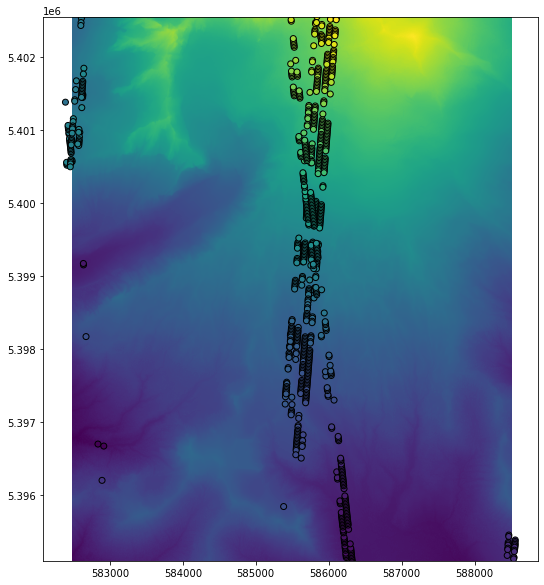

In [7]:


fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
ddf_gpd.plot(ax=ax, column='h_li', edgecolor='black')




6. Calculating difference

Partly from Fredrick's code

In [8]:
import rasterio
import rasterio.sample as rio_sample

rio_ds = rasterio.open(dem_path)
ddf_xytuple = list(ddf_gpd[['x', 'y']].to_records(index=False))
# print(ddf_xytuple)
sample_gen = rio_ds.sample(ddf_xytuple)
rasterddf_gpd = gpd.GeoDataFrame()

h_raster = [float(record) for record in sample_gen]
# print(h_raster)
ddf_gpd['h_raster'] = h_raster
ddf_gpd['li_raster'] = ddf_gpd['h_li'] - ddf_gpd['h_raster']



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

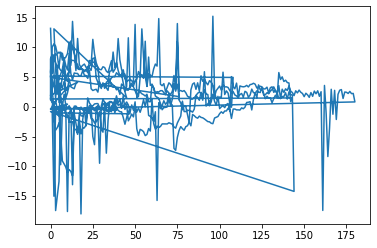

In [9]:
%matplotlib widget

tmp = ddf_gpd[ddf_gpd['li_raster'] < 20]
ddf_gpd_cleaned = tmp[tmp['li_raster'] > -20]

plt.plot(ddf_gpd_cleaned['li_raster'])


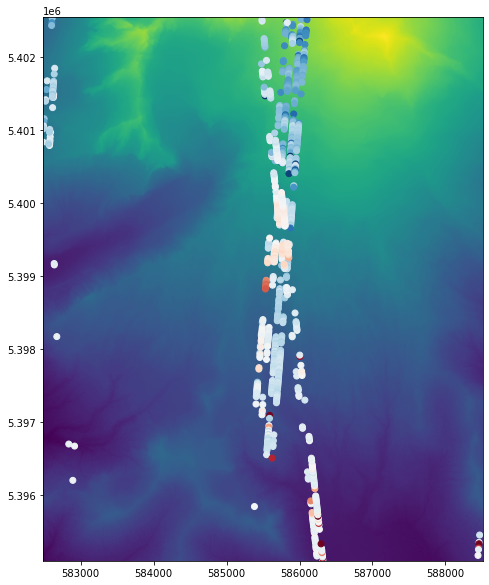

In [10]:
%matplotlib inline

fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
ddf_gpd_cleaned.plot(ax=ax, column='li_raster', cmap='RdBu', clim=[-20, 20])

7. interpolating ICESat-2

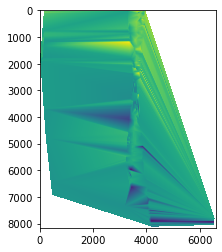

In [11]:
from scipy import interpolate

ddf_xy_cleaned = list(zip(ddf_gpd_cleaned['x'], ddf_gpd_cleaned['y']))
# print(type(ddf_xy_cleaned))

grid_x, grid_y = np.meshgrid(dem.x, dem.y)
# print(np.random.rand(1000, 2))

# print(ddf_xy_cleaned)

grid_off = interpolate.griddata(ddf_xy_cleaned, list(ddf_gpd_cleaned['li_raster']), (grid_x, grid_y), method='linear')

plt.imshow(grid_off)

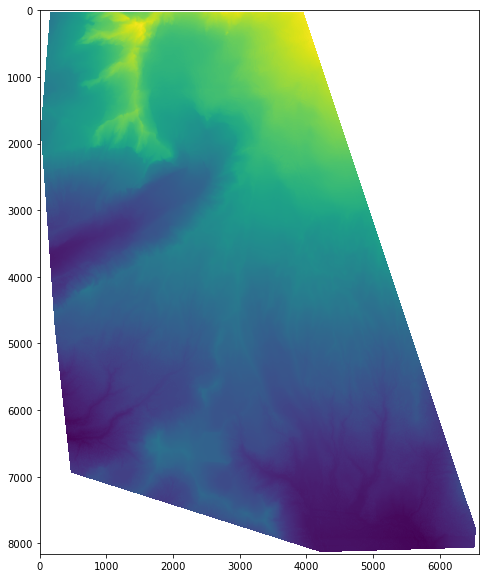

In [12]:
# print(grid_off.shape)
# print(dem.dem.shape)

plt.figure(figsize=(10,10))
plt.imshow(grid_off + dem.dem)